# Recommender System Part II

blog post url:
http://blog.supersingularity.co/recommender-syst…ens-data-part-ii/

## Model-based recommender system

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data_df = pd.read_csv('u.data',delimiter='\t',names=['user_id', 'item_id', 'rating', 'timestamp'])

## Pre-processing

Split data into training and testing

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_df, test_size=.25)

In [4]:
# create pivot tables for training data and test data to make sure they have the same shape (num_user, num_movie)
def create_pivot_table(data, num1, num2):
    pivot_table = np.empty((num1, num2))
    pivot_table[:] = np.nan
    for row in data:
        pivot_table[row[0]-1, row[1]-1] = row[2]
    return pivot_table

In [5]:
num_users = len(data_df['user_id'].unique())
num_movies = len(data_df['item_id'].unique())

In [7]:
cocur_train = create_pivot_table(train.values, num_users, num_movies)
cocur_train.shape

(943, 1682)

In [8]:
cocur_test = create_pivot_table(test.values, num_users, num_movies)
cocur_test.shape

(943, 1682)

In [9]:
np.save('train_mf', cocur_train)
np.save('test_mf', cocur_test)

In [10]:
train = np.load('train_mf.npy')
test = np.load('test_mf.npy')

## Model-based RS

In [23]:
# compute the cost function
from numpy import linalg
def cost(data, users, movies, reg_factor):
    diff = np.dot(users, np.transpose(movies)) - data
    reg = reg_factor * (linalg.norm(users,'fro') ** 2 + linalg.norm(movies,'fro') ** 2)
    return np.nansum(np.multiply(diff, diff)) + reg
    

In [78]:
def initialize(user_num, movie_num, k):
    users = np.random.normal(size=(user_num,k))
    users.reshape((user_num,k))
    movies = np.random.normal(size=(movie_num, k))
    movies.reshape((movie_num, k))
    return users, movies

In [29]:
# compute the gradient of the cost functions
# index denote the index of the user vector/movie vector we are computing the derivative for
def gradient_user(data, movies, user_vec, index, reg_factor):
    i = 0
    grad = np.zeros(user_vec.shape)
    for m in movies:
        if not np.isnan(data[index][i]):
            change = 2* ( np.dot(user_vec, np.transpose(m)) - data[index][i]) * m  
            grad = grad + change 
        i += 1   
    grad = grad + 2* reg_factor * user_vec 
    return grad
        
    
def gradient_movie(data, movie_vec, users, index, reg_factor):
    i = 0
    grad = np.zeros(movie_vec.shape)
    for m in users:
        if not np.isnan(data[i][index]):
            change = 2* (np.dot(m, np.transpose(movie_vec))- data[i][index]) * m
            grad = grad + change
        i += 1
    grad = grad + 2* reg_factor * movie_vec
    return grad

In [125]:
def train_model(train_data, test_data, latent_factor, reg_factor, learning_rate, iterations):
    costs = []
    train_err = []
    test_err = []
    (user_num, movie_num) = train_data.shape
    users, movies = initialize(user_num, movie_num, latent_factor)
    for i in range(0, iterations):
        user_index = 0
        movie_index  = 0
        old_users = users
        for u in users:
            users[user_index] = u - learning_rate * gradient_user(train_data, movies, u, user_index,reg_factor)
            user_index += 1
        for m in movies:
            movies[movie_index] = m - learning_rate * gradient_movie(train_data, m, old_users, movie_index, reg_factor)
            movie_index += 1
        if (i%50 == 0):
            print('iteration ')
            print(i)
            curr_cost = cost(train_data, users, movies, reg_factor)
            training_error = test_model(train_data, users, movies)
            test_error = test_model(test_data, users, movies)
            costs.append(curr_cost)
            train_err.append(training_error)
            test_err.append(test_error)
            print('training cost is')
            print(curr_cost)
            print('training error is')
            print(training_error)
            print('test error is')
            print(test_error)
    return users, movies, costs, train_err, test_err
            
        
    

In [84]:
def make_plots(costs, train_err, test_err, latent_factor, reg_factor):
    fig, axs = plt.subplots(1,2)
    fig.suptitle('latent factor = '+str(latent_factor) + ' regularization factor = '+str(reg_factor))
    axs[0].set_xlabel('iterations')
    axs[0].set_ylabel('cost')
    axs[1].set_xlabel('iterations')
    axs[1].set_ylabel('RMSE')
    x = [50*i for i in range(0,len(costs))]
    axs[0].plot(x,costs,label='cost')
    axs[1].plot(x, train_err, label='training error')
    axs[1].plot(x, test_err, label='testing error')
    axs[1].legend()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    fig.savefig('k_'+str(latent_factor)+'r_'+str(reg_factor)+'.png')

In [47]:
from math import sqrt
def test_model(test_data, users, movies):
    data_cnt = np.isnan(test_data).size - np.sum(np.isnan(test_data)) # count non-nan entries
    return sqrt(cost(test_data,users, movies, 0.0) * 1.0/data_cnt)

    

### Grid Search

We search the best performing set of the number of latent factors and the regularization parameter.

In [88]:
latent_factors = [5, 10, 20, 40]
reg_factors = [0.1, 1., 10.]

In [87]:
#Plot the cost, training error and testing error for each set of hyperparameters and save the plot
def param_selection(latent_factors, reg_factors):
    cost_all = []
    train_err_all = []
    test_err_all = []
    for reg_factor in reg_factors:
        for latent_factor in latent_factors:
            print('latent factor is ')
            print(latent_factor)
            print('regularization factor is ')
            print(reg_factor)
            _,_, costs, train_err, test_err = train_model(train, test, latent_factor, reg_factor, .001, 501)
            cost_all.append(costs)
            train_err_all.append(train_err)
            test_err_all.append(test_err)
            make_plots(costs, train_err, test_err, latent_factor, reg_factor)
    return cost_all, train_err_all, test_err_all

latent factor is 
5
regularization factor is 
0.1
iteration 
0
training cost is
1127641.83558
training error is
3.875584422807847
test error is
3.9247668212499396
iteration 
50
training cost is
272535.175665
training error is
1.9019243678305233
test error is
2.0711972297819
iteration 
100
training cost is
173178.942099
training error is
1.5138143761118454
test error is
1.6826303765747261
iteration 
150
training cost is
139311.695871
training error is
1.3562520987249689
test error is
1.5310288440453486
iteration 
200
training cost is
121806.211433
training error is
1.2670797310419355
test error is
1.4498316053277829
iteration 
250
training cost is
111091.509769
training error is
1.2092072886769307
test error is
1.4000735235273853
iteration 
300
training cost is
103830.52463
training error is
1.1683220920010147
test error is
1.3669076940915235
iteration 
350
training cost is
98578.7305873
training error is
1.137805285191841
test error is
1.343435399605139
iteration 
400
training cost is


training error is
1.1258982192906017
test error is
1.6270491896867965
iteration 
150
training cost is
99621.9367743
training error is
0.9905474561072654
test error is
1.5170677733158382
iteration 
200
training cost is
87073.1603214
training error is
0.9183448007898539
test error is
1.4616103337352178
iteration 
250
training cost is
79389.3437306
training error is
0.8743081552104403
test error is
1.4292859976429786
iteration 
300
training cost is
74198.4210752
training error is
0.8448699553201288
test error is
1.408411330801196
iteration 
350
training cost is
70452.907612
training error is
0.8237230364073427
test error is
1.3937835110624264
iteration 
400
training cost is
67616.7916943
training error is
0.807606437920256
test error is
1.3829108897278897
iteration 
450
training cost is
65406.3883514
training error is
0.7948728059929395
test error is
1.3746167122427708
iteration 
500
training cost is
63646.3754414
training error is
0.7845416855611136
test error is
1.3682278082138835
laten

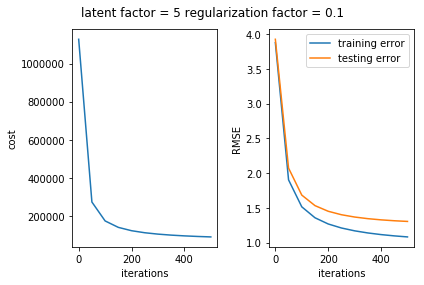

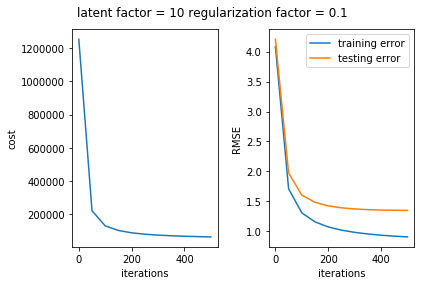

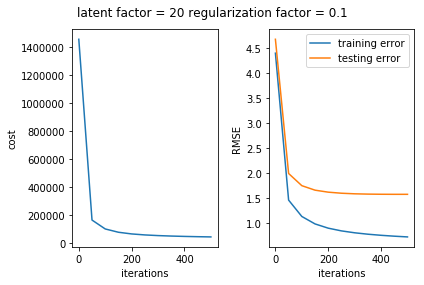

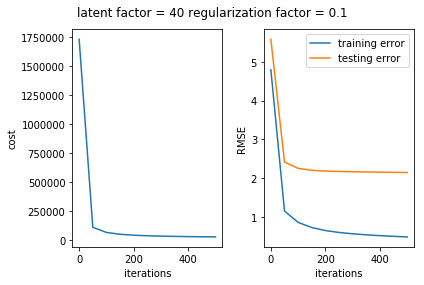

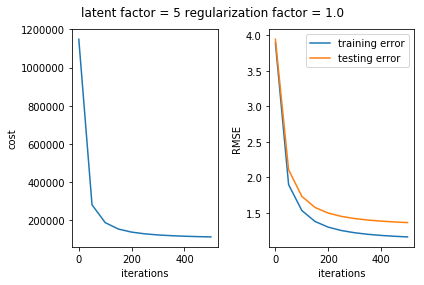

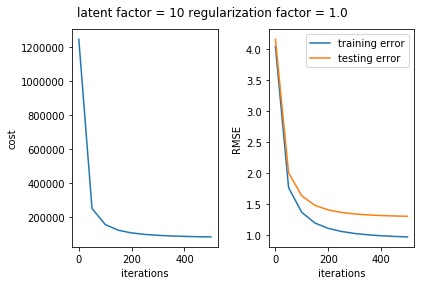

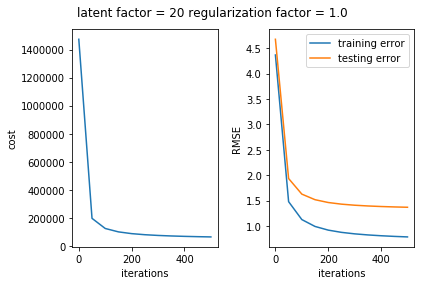

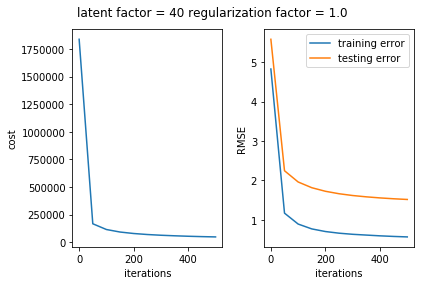

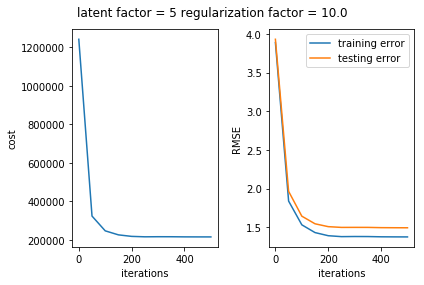

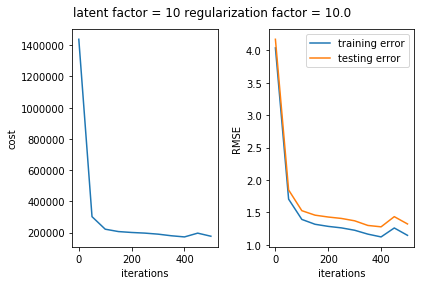

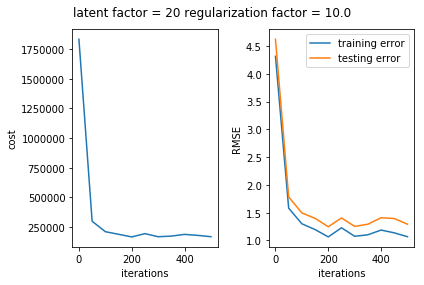

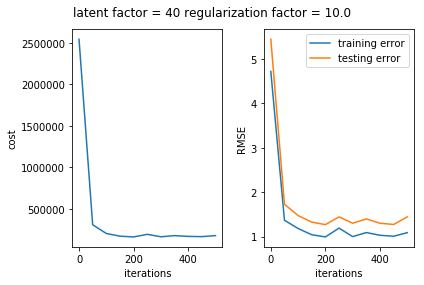

In [93]:
cost_all, train_err_all, test_err_all = param_selection(latent_factors, reg_factors)

We can notice some trends here.
As we can see, as the regularization parameter gets to as big as 10.0, gradient descent is not very stable.  So we get some fluctuations in performances. As the number of latent factors gets bigger, the gap between training error and test error also increases.  This is a sign that the model is overtrained.  This phenomenon is especially obvious when k=40 (but also notice that it is somewhat migitated by regularization, thus the increase in performance for k=40 when the regularization parameter increases).

In [97]:
np.save('cost_vecs',cost_all)
np.save('train_err_vecs', train_err_all)
np.save('test_err_vecs', test_err_all)

In [94]:
test_err_all

[[3.9247668212499396,
  2.0711972297819,
  1.6826303765747261,
  1.5310288440453486,
  1.4498316053277829,
  1.4000735235273853,
  1.3669076940915235,
  1.343435399605139,
  1.3262573280710719,
  1.3134236663363543,
  1.3037134158634591],
 [4.206146312806897,
  1.974483020888873,
  1.6042626468438614,
  1.4844077530216913,
  1.425472438813586,
  1.3931348758732165,
  1.3739729362631359,
  1.3623808116990723,
  1.3555405054112413,
  1.3517510466884992,
  1.3499303152424935],
 [4.67550063226702,
  1.9895830393266059,
  1.7458380559323587,
  1.655977483115284,
  1.6158976631908222,
  1.5947591747311296,
  1.5830420837099253,
  1.576961656938757,
  1.5739941850658954,
  1.5727454566570513,
  1.57282482765101],
 [5.578440164509681,
  2.4191562968435667,
  2.2563650555406354,
  2.208036342852238,
  2.1879493351463917,
  2.177375349166515,
  2.170363176795417,
  2.1648719935424605,
  2.159925735688267,
  2.1550457147523767,
  2.1501285782948005],
 [3.945859185953867,
  2.1066721116149787,
  1

Make a plot that compares the performances of different set of hyperparameters.

In [95]:
# create labels
labels = []
for reg_factor in reg_factors:
        for latent_factor in latent_factors:
            labels.append('k_'+str(latent_factor)+'r_'+str(reg_factor))

Matplotlib gives a mess that you can't really tell which line belongs to which set of parameters.

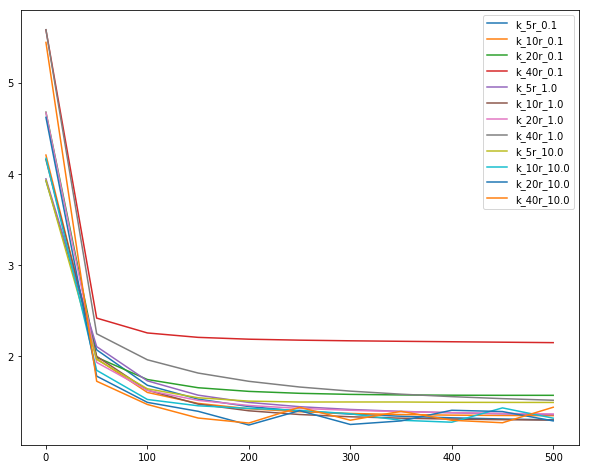

In [102]:
fig2,ax2 = plt.subplots(figsize=(10,8))
x = [50*i for i in range(0,len(test_err_all[0]))]
i = 0
for e in test_err_all:
    ax2.plot(x,e,label=labels[i])
    i += 1
ax2.legend(loc='best')

Use plotly to make the plot because it allows us to zoom in and show the values of the data points when we hover over the plot.

In [111]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [130]:
traces = []
x = [50*i for i in range(0,len(test_err_all[0]))]
for i in range(0,len(test_err_all)):
    trace = go.Scatter(x = x, y = test_err_all[i], name = labels[i])
    traces.append(trace)
    
layout = go.Layout(
    title='Test error over 500 iterations',
    xaxis=dict(
        title='iteration'
    ),
    yaxis=dict(
        title='test error'
    )
)
fig3 = go.Figure(data=traces, layout=layout)

In [131]:
iplot(fig3)

As we can see k=5 r=0.1 gives very stable performance (steady decreases in test error as the number of iterations increase), and k=5 gives the lowest dimension at almost no sacrifice of performances.  So this will be the set of parameters we choose.